--------
# Analysis of Zimbabwe's July 2018 Presidential Elections based on official voters' roll data and election results data
--------
### **Date: August 8th, 2018**

### **Disclaimer**: This analysis is a review of election data as presented by the Zimbabwe Electoral Commission (ZEC) and is not meant to be a review of the election exercise itself. The monitoring and review of elections is the job of ZEC, election stakeholders, political parties, citizens of Zimbabwe and election observers. The author takes no responsibility for any consequences resulting from unintended uses of this data.  

### Intro
This analyses uses only 2 official data sources 1) Zimbabwe Electoral Commission (ZEC) Voters Roll and 2) ZEC Election Results. The former was provided through a dropbox link (can be provided upon request) after court ordered ZEC to release it while the latter was released on the ZEC website here https://www.zec.org.zw/pages/election_results2018. Highlights the following issues:

### Voters Roll Data Summary
- There are **5,695,671** registered at **10985** polling stations
- About **54%** of the registered voters were female
- The average number of registrered voters per polling station was **518**.
- One polling stations had **6** while another had **1000 registered voters**
- However, most stations had **between 300 and 700 registered voters**

### Election Results Data Summary
- About **98.5%** of all votes cast were valid, with the rest being either rejected or unaccounted for
- About **~4.843 million** people voted out of possible ~5.696 million giving a overall voter turnout of **85%**
- In this dataset provided by ZEC, Mnangagwa, Chamisa obtained **50.66%, 44.38%** respectively. This differs from the official announced numbers of **50.8%, 44.3%** respectively
- The data shows Mnangagwa and Chamisa both got **2,453,742** and **2,1494,512** which are also different from the stated (wikipedia) **2,460,463** and **2,147,436** respectively
- Some of these anomalies many be explained by the fact that there are some missing, new, and duplicated polling stations which come up when the voters roll and election results are compared
- There may have also been other errors e.g. in transcribing and/or stating and recornging the numbers 
- Mnangagwa dominated the rural provinces while Chamisa won the metro and urban areas

### Election Results Data vs Voters Roll Data Comparison
#### **22 polling stations found in voters roll but not in election results**
 - These 22 represent more than 8000 votes with the majority being in Masvingo (>2000 votes)
 - Masvingo also has the highest number (7) of 'missing' polling stations
 - Alternative explanation: this could be a data entry error, but worth looking into

#### **3 polling stations found in the election results but not in the voters roll** 
 - These 3 represent about 1200 votes cast in the election
 - Alternative explanation: this could be a data entry error, but worth looking into

#### **7 polling stations duplicated in the data**, representing more than 4000 votes cast
 - Each polling station appears twice, with different data on the votes
 - The vote distribution in the duplicated polling stations is skewed towards Mnangagwa and against Chamisa in all but one station

#### **630 sites with over 90% voter turnout**, shows distribution of results in these stations across candidates and across provinces
 - mostly in Mash Central, skewed in favor of Mnangagwa
 - Alternative explanation: Note that it is possible that Mnangagwa campaigned hard in these areas to get high turnout, but these numbers are very high so need to be looked at closely

#### **32 sites with over 95% voter turnout**, shows distribution of results in these stations across candidates and across provinces
 - mostly in Mash Central again, still skewed in favor of Mnangagwa
 - Alternative explanation: Note that it is possible that Mnangagwa campaigned hard in these areas to get high turnout, but these numbers are very high so need to be looked at closely

#### **12 sites with over 100% voter turnout**, shows distribution of results in these stations across candidates and across provinces
 - mostly in Masvingo, but this time less skewed. In fact more evenly distributed
 - Of course, the results from these can never be trusted at >100% turnout!
 - These must be reviewed at the very least.
 
### Mathematical Integrity of the elections data
- 94 polling stations had the sum of votes for candidates plus all rejected and unaccounted ballots EXCEEDING the recorded total vote
- These were mostly in Mashonaland central and Bulawayo
- 5 polling stations had the sum of votes for candidates plus all rejected and unaccounted ballots BELOW the recorded total vote

More analysis could be done on this, including comparisons with past voters rolls and results. **On its own, this data may not be conclusive (except where we saw >100% turnout!) of any election fraud**. However, if corroborated with other data sources, it may. It may also be used to narrow down the search of which polling stations and geographies to target for further verisfication and review.

In [1024]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import itertools
import os
import pivottablejs as pvt
from tabula import read_pdf
import matplotlib.ticker as tic

%matplotlib inline

### Load and Combine Election Results and Voter Registration data
Load and combine data that was already transformed and prepared for this purpose, using ZEC voters roll and elections results (all official sources) as data sources

In [1025]:
# Read combined data
d_election  = pd.read_excel("election_data_clean_forScript.xlsx")
d_election.shape

(10970, 36)

In [1026]:
# voters
dvoters = pd.read_excel("votersroll_bypolstat_clean.xlsx")
dvoters.shape

(10985, 13)

In [1027]:
# results
dresults = pd.read_excel("results_bypolstat_clean.xlsx")
dresults.shape

(10973, 34)

In [1028]:
def getNumCols(df):
    df = df._get_numeric_data()
    df_cols = [c for c in df.columns if ('pct' not in c and 'check_sum' not in c)]
    #print(df.columns, df_cols)
    return df_cols

def sep1000Formatter(n):
    return "{:,}".format(int(n))

# Cool way to dynamically change font size based on number of bars on bar chart
def scaleFont(bnew, bbase, fbase):
    """ takes number of bars, the baseline bars and corresponding baseline font and returns recommended fontsize"""
    # 8 bars get fontsize 12?
    return 16 if bnew==1 else int(np.log(bbase)/np.log(bnew)) + fbase +1

dnumE_cols = getNumCols(d_election)
dnumV_cols = getNumCols(dvoters)
dnumR_cols = getNumCols(dresults)

In [1029]:
# Format all numbers to include 1000 seperator
#de = d_election.copy()
#for c in dnumE_cols:
#    de.loc[:,c] = de[c].apply(lambda x: "{:,}".format(int(x)))
#de.groupby('province_vot').sum()

In [1030]:
# Change province names
dvp = set(dvoters.province)
drp = set(dresults.province)
dep = set(d_election.province_vot)

#dvp
dvp_map={'bulawayo metropolitan':'bulawayo',
 'harare metropolitan': 'harare',
 'manicaland': 'manicaland',
 'mashonaland central': 'mash central',
 'mashonaland east': 'mash east',
 'mashonaland west': 'mas west',
 'masvingo': 'masvingo',
 'matabeleland north': 'mat north',
 'matabeleland south':'mat north',
 'midlands': 'midlands'}
#drp
drp_map = {'bulawayo metropolitan province': 'bulawayo',
 'harare metropolitan province': 'harare',
 'manicaland province province': 'manicaland',
 'mashonaland central province': 'mash central',
 'mashonaland east province': 'mash east',
 'mashonaland west  province': 'mash west',
 'masvingo province': 'masvingo',
 'matabeleland north province': 'mat north',
 'matabeleland south province': 'mat south',
 'midlands province': 'midlands'}
#dep
dep_map = {'bulawayo metropolitan': 'bulawayo',
 'harare metropolitan': 'harare',
 'manicaland':'manicaland',
 'mashonaland central':'mash central',
 'mashonaland east': 'mash east',
 'mashonaland west': 'mash west',
 'masvingo': 'masvingo',
 'matabeleland north':'mat north',
 'matabeleland south': 'mat south',
 'midlands': 'midlands'}

dvoters.loc[:,'province'] = dvoters['province'].map(dvp_map)
dresults.loc[:,'province'] = dresults['province'].map(drp_map)
d_election.loc[:,'province_vot'] = d_election['province_vot'].map(dep_map)

----
# Main Analysis
----

Now that data is loaded and combined, begin the core analysis piece

## PART 1 - Voters Roll summary
-------
- There are 5,695,671 registered at 10985 polling stations
- About 54% of the registered voters were female
- The average number of registrered voters per polling station was 518.
- One polling stations had 6 while another 1000 registered voters
- However, most stations had between 300 and 700 registered voters

In [1031]:
print("Gender counts\n----------\n", dvoters[['male_count', 'female_count', 'tot_count']].sum(), '\n')
print("Female proportion \n----------\n", dvoters[['male_count', 'female_count', 'tot_count']].sum()['female_count']/dvoters[['male_count', 'female_count', 'tot_count']].sum()['tot_count'])

Gender counts
----------
 male_count      2622497
female_count    3073174
tot_count       5695671
dtype: int64 

Female proportion 
----------
 0.539563117322


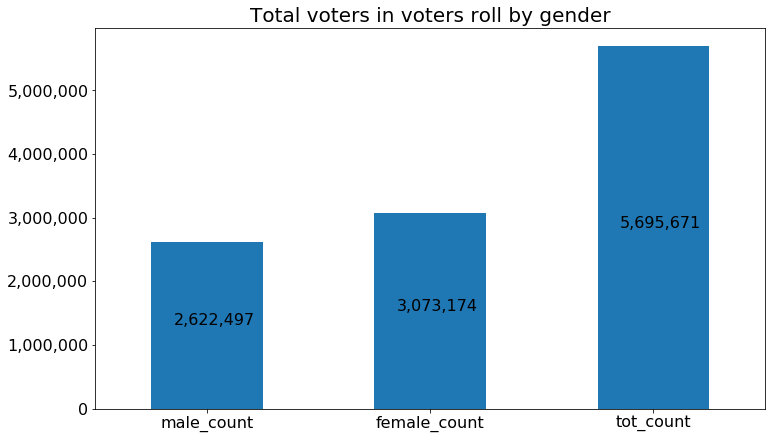

In [1032]:
d = dvoters[['male_count', 'female_count','tot_count']].sum()
g = d.plot(kind="bar", stacked=True, figsize=(12,7), title="Total voters in voters roll by gender", fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for i in range(len(d)):
    g.text(i-0.15, d[i]/2,  sep1000Formatter(d[i]), fontsize=16)
g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

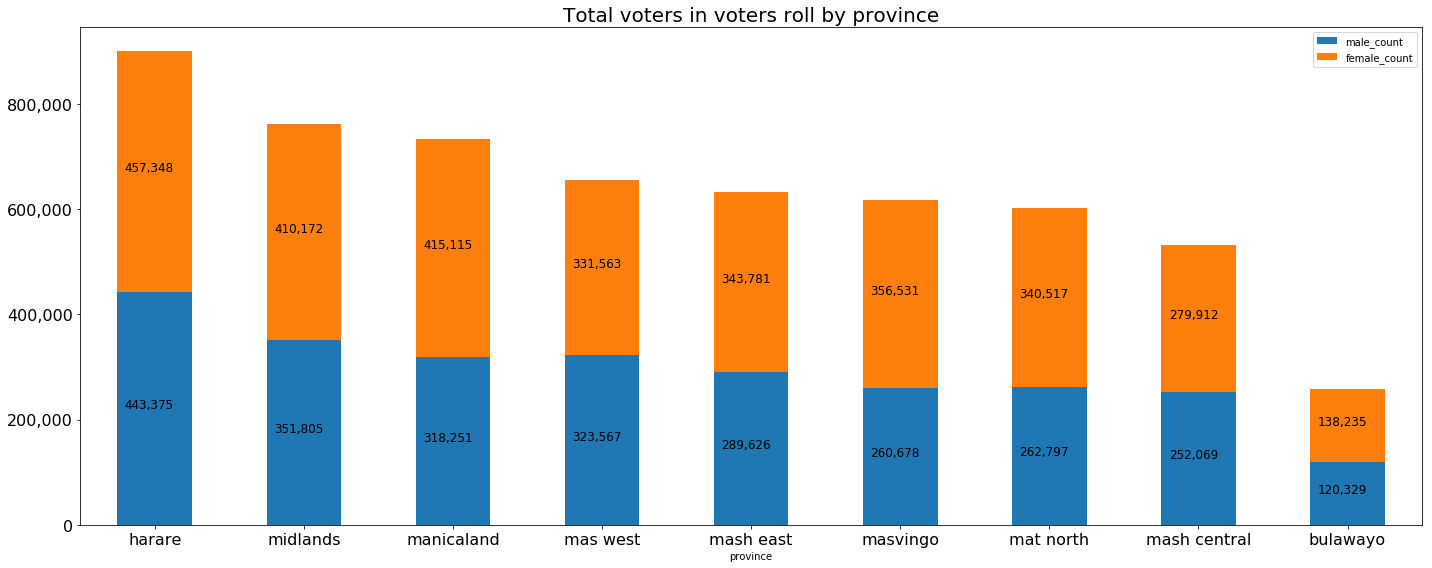

In [1103]:
d = dvoters.groupby(['province']).agg(sum).sort_values(by='tot_count', ascending=False)[['male_count', 'female_count']]
g = d.plot(kind="bar", stacked=True, figsize=(20,8), title="Total voters in voters roll by province", fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for i in range(len(d)):
    g.text(i-0.2, d.iloc[i,0]/2,  sep1000Formatter(d.iloc[i,0]), fontsize=12)
    g.text(i-0.2, d.iloc[i,0]+d.iloc[i,1]/2,  sep1000Formatter(d.iloc[i,1]), fontsize=12)
g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

Text(0.5,1,'Distribution of number of registrants per polling station')

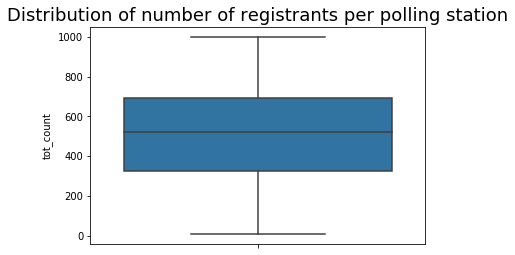

In [1034]:
sns.boxplot( y=dvoters['tot_count'])
plt.title("Distribution of number of registrants per polling station",size=18)

## PART 2 - Election results summary
-------

- About **98.5%** of all votes cast were valid, with the rest being either rejected or unaccounted for
- About **~4.843 million** people voted out of possible ~5.696 million giving a overall voter turnout of **85%**
- In this dataset provided by ZEC, Mnangagwa, Chamisa obtained **50.66%, 44.38%** respectively. This differs from the official announced numbers of **50.8%, 44.3%** respectively
- The data shows Mnangagwa and Chamisa both got **2,453,742** and **2,1494,512** which are also different from the stated (wikipedia) **2,460,463** and **2,147,436** respectively
- Some of these anomalies many be explained by the fact that there are some missing, new, and duplicated polling stations which come up when the voters roll and election results are compared
- There may have also been other errors e.g. in transcribing and/or stating and recornging the numbers 
- Mnangagwa dominated the rural provinces while Chamisa won the metro and urban areas

Text(0.5,1,'Distribution of number of votes per polling station')

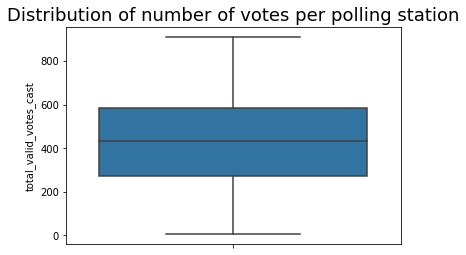

In [1035]:
sns.boxplot( y=dresults['total_valid_votes_cast'])
plt.title("Distribution of number of votes per polling station",size=18)

### National voter turnout - Total votes vs registered voters

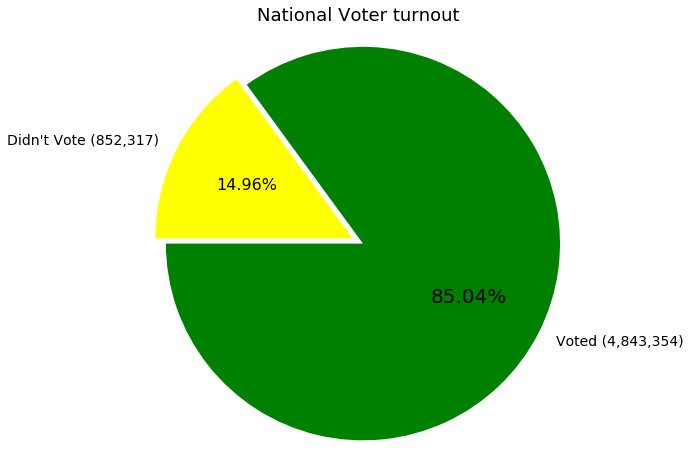

In [1036]:
f = plt.figure(figsize=(8,8))

tv=int(dresults[['total_votes_rejected',  'ballot_paper_unaccounted_for', 'total_valid_votes_cast']].sum().sum())
tr = dvoters['tot_count'].sum()

sizes = tv, tr-tv
labels = 'Voted ('+sep1000Formatter(int(sizes[0]))+')',  "Didn't Vote ("+ sep1000Formatter(int(sizes[1]))+')'
colors = ['green', 'yellow']
explode = (0.01, 0.05)  # explode slicesa
 
# Plot
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.2f%%', startangle=180, radius=1) 
plt.axis('equal')
plt.title("National Voter turnout", size=18)
texts[0].set_fontsize(14);texts[1].set_fontsize(14)
autotexts[0].set_fontsize(20);autotexts[1].set_fontsize(16)
plt.show()

### What proportion of votes were rejected?

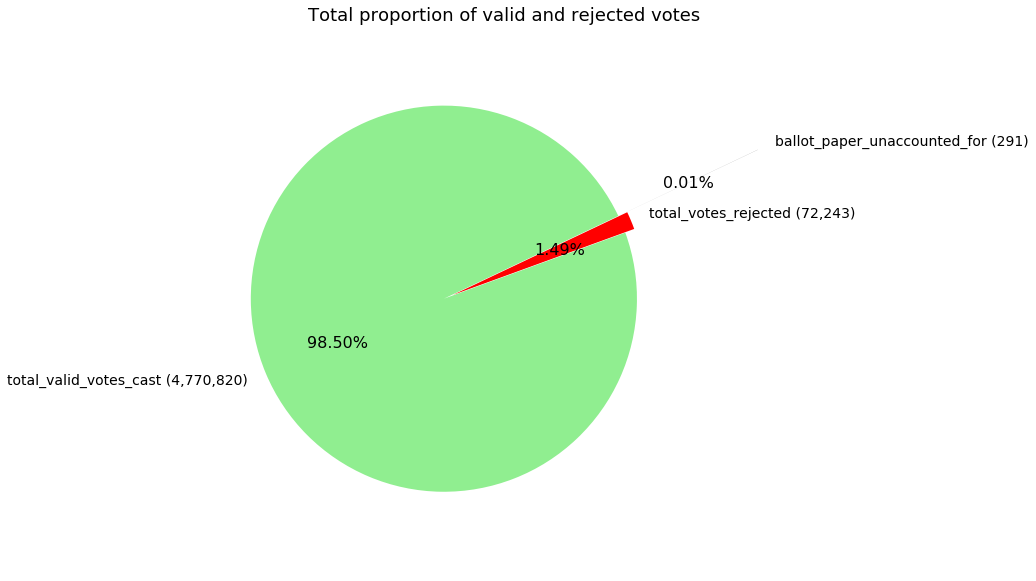

In [1102]:
f = plt.figure(figsize=(10,10))

sizes = dresults[['total_votes_rejected',  'ballot_paper_unaccounted_for', 'total_valid_votes_cast']].sum()
labels = ['total_votes_rejected ('+sep1000Formatter(int(sizes[0]))+')', 
'ballot_paper_unaccounted_for ('+ sep1000Formatter(int(sizes[1]))+')', 'total_valid_votes_cast ('+sep1000Formatter(int(sizes[2]))+')']
colors = ['red', 'black',  'lightgreen']
explode = (0.05, 0.8, 0.)  # explode slicesa
 
# Plot
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.2f%%', startangle=20, radius=1) 
plt.axis('equal')
plt.title("Total proportion of valid and rejected votes", size=18)
texts[0].set_fontsize(14);texts[1].set_fontsize(14);texts[2].set_fontsize(14)
autotexts[0].set_fontsize(16);autotexts[1].set_fontsize(16);autotexts[2].set_fontsize(16)
plt.show()

### How many votes did each candidate get?

In [1038]:
# Get candidate columns
all_cand_cols = other_cols = ['busha_joseph_makamba_freezim_congress',
'chamisa_nelson_mdc_alliance',
    'chikanga__everisto_washington_rebuild_zimbabwe',
       'dzapasi_melbah_#_1980_freedom_movement_zimbabwe',
       'gava_peter_mapfumo_udf', 'hlabangana_kwanele_rpz',
       'kasiyamhuru_blessing_zpp', 'khupe_thokozani_mdc-t',
       'madhuku_lovemore_nca', 'mangoma_elton_steers_coalition_of_democrats',
       'manyika_noah_ngoni_bza',
       'mapfumo_chiguvare_tonderayi_johannes_timothy_pppz',
       'mariyacha_violet_udm', 'mhambi-hove_divine_napdr',
'mnangagwa_emmerson_dambudzo_zanu_pf', 
    'moyo_donald_nkosana_apa',
       'mteki_bryn_taurai_independent', 'mugadza_willard_tawonezvi_bcp',
       'mujuru_joice_teurai_ropa_prc', 'munyanduri_tenda_peter_npf',
       'mutinhiri_ambrose_npf', 'shumba_kuzozvirava_doniel_uda',
       'wilson_peter_harry_dop']

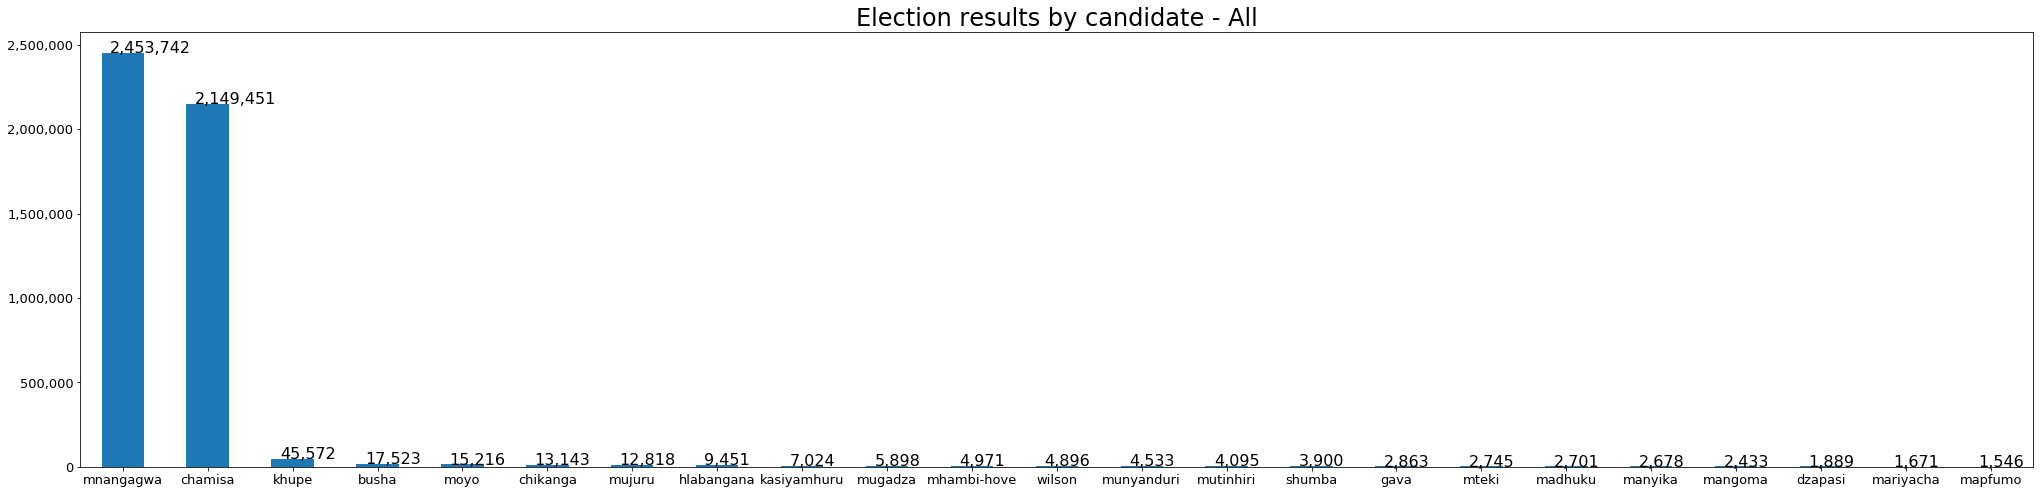

In [1039]:
d= dresults.sum()[all_cand_cols].sort_values(ascending=False).sort_values(ascending=False)
d.index = [c.split('_')[0] for c in d.index]
g= d.plot(kind='bar', figsize=(35,8), title="Election results by candidate - All", fontsize=13)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(24)
for i in range(len(d)):
    g.text(i-0.15, d[i],  sep1000Formatter(d[i]), fontsize=16)
g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

In [1040]:
# extract columns
other_cols = ['busha_joseph_makamba_freezim_congress',
#'chamisa_nelson_mdc_alliance',
    'chikanga__everisto_washington_rebuild_zimbabwe',
       'dzapasi_melbah_#_1980_freedom_movement_zimbabwe',
       'gava_peter_mapfumo_udf', 'hlabangana_kwanele_rpz',
       'kasiyamhuru_blessing_zpp', 'khupe_thokozani_mdc-t',
       'madhuku_lovemore_nca', 'mangoma_elton_steers_coalition_of_democrats',
       'manyika_noah_ngoni_bza',
       'mapfumo_chiguvare_tonderayi_johannes_timothy_pppz',
       'mariyacha_violet_udm', 'mhambi-hove_divine_napdr',
#'mnangagwa_emmerson_dambudzo_zanu_pf', 
    'moyo_donald_nkosana_apa',
       'mteki_bryn_taurai_independent', 'mugadza_willard_tawonezvi_bcp',
       'mujuru_joice_teurai_ropa_prc', 'munyanduri_tenda_peter_npf',
       'mutinhiri_ambrose_npf', 'shumba_kuzozvirava_doniel_uda',
       'wilson_peter_harry_dop']
# Calculate the totals and make new column in df
others = dresults[other_cols].sum(axis=1)

dvotcalc = dresults.copy();  dvotcalc['others_excl_NCandED'] = others
# Drop individual others, now redundant
try:
    dvotcalc.drop(other_cols, axis=1, inplace=True)
except:
    pass
print(dvotcalc.shape)
#dvotcalc

(10973, 14)


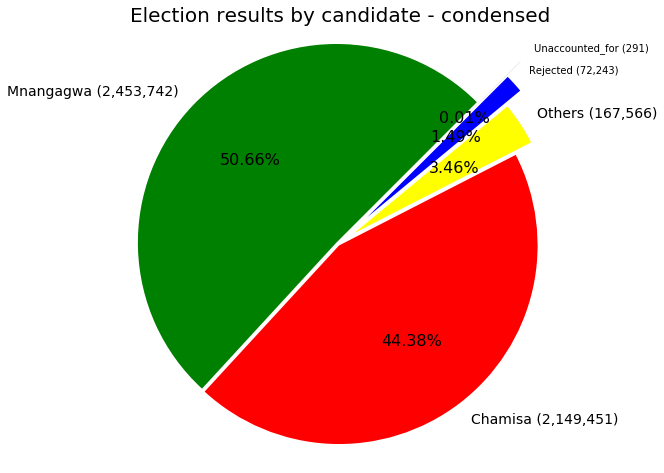

In [1143]:
f = plt.figure(figsize=(8,8))

sizes = dvotcalc[['mnangagwa_emmerson_dambudzo_zanu_pf','chamisa_nelson_mdc_alliance', 'others_excl_NCandED',
                  'total_votes_rejected', 'ballot_paper_unaccounted_for']].sum()
labels = ['Mnangagwa ('+sep1000Formatter(int(sizes[0]))+')',  'Chamisa ('+ sep1000Formatter(int(sizes[1]))+')', 
'Others ('+sep1000Formatter(int(sizes[2]))+')', 'Rejected ('+sep1000Formatter(int(sizes[3]))+')' , 'Unaccounted_for ('+sep1000Formatter(int(sizes[4]))+')']
colors = ['green', 'red',  'yellow', 'blue', 'black']
explode = (0.010, 0.01, 0.1, 0.2, 0.3)  # explode slicesa
 
# Plot
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.2f%%', startangle=45, radius=1) 
plt.axis('equal')
plt.title("Election results by candidate - condensed", size=20)
texts[0].set_fontsize(14);texts[1].set_fontsize(14);texts[2].set_fontsize(14);autotexts[3].set_fontsize(16);autotexts[4].set_fontsize(16)
autotexts[0].set_fontsize(16);autotexts[1].set_fontsize(16);autotexts[2].set_fontsize(16);autotexts[3].set_fontsize(16);autotexts[4].set_fontsize(16)
plt.show()

### What were the candidate results per province?

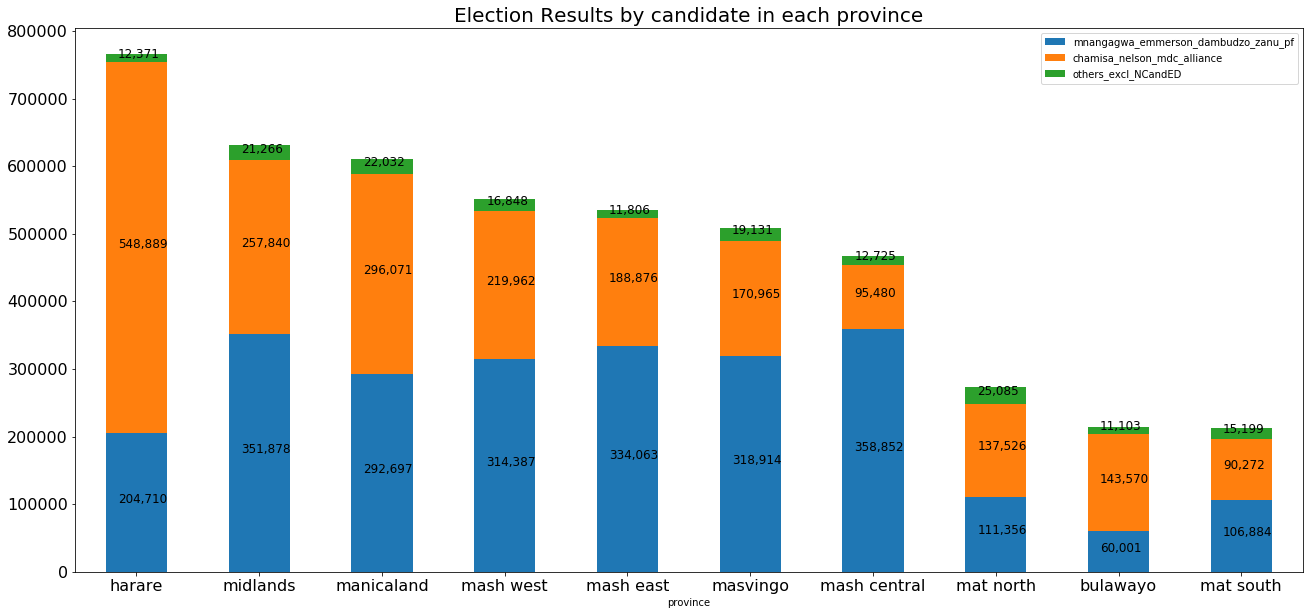

In [1100]:
d = dvotcalc.groupby(['province']).sum()[['mnangagwa_emmerson_dambudzo_zanu_pf','chamisa_nelson_mdc_alliance', 'others_excl_NCandED','total_valid_votes_cast' ]].sort_values(
    by=['total_valid_votes_cast'], ascending=False).drop(['total_valid_votes_cast'], axis=1)
g = d.plot(kind="bar", stacked=True, figsize=(22,10), title="Election Results by candidate in each province", fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for i in range(len(d)):
    g.text(i-0.15, d.iloc[i,0]/2,  sep1000Formatter(int(d.iloc[i,0])), fontsize=12)
    g.text(i-0.15, d.iloc[i,0]+d.iloc[i,1]/2,  sep1000Formatter(int(d.iloc[i,1])), fontsize=12)
    g.text(i-0.15, d.iloc[i,0]+d.iloc[i,1]+d.iloc[i,2]/2,  sep1000Formatter(int(d.iloc[i,2])), fontsize=12)

### In each province, what was the distributiuon of votes?

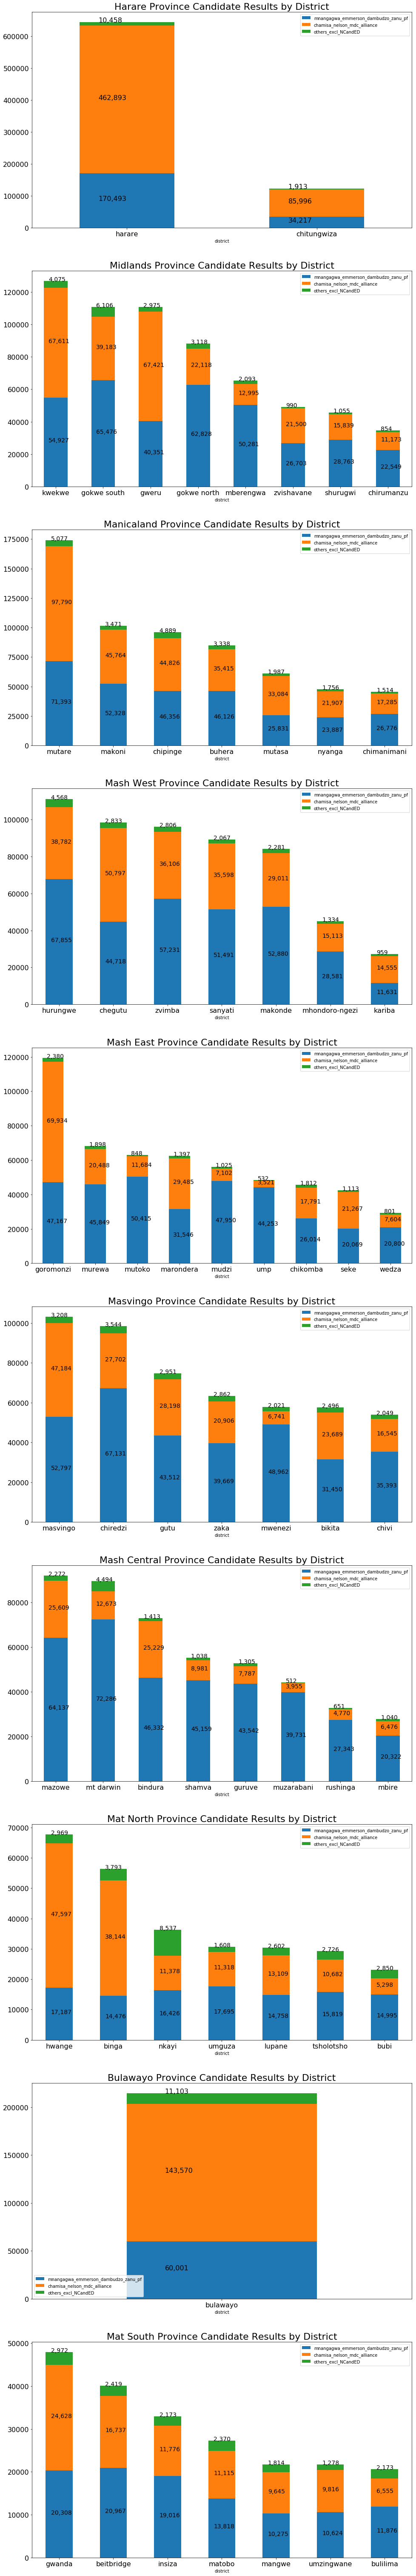

In [1140]:
prov_list = list(dvotcalc[['province', 'total_valid_votes_cast']].groupby(['province']).sum().sort_values(by =['total_valid_votes_cast'], ascending=False).index)
#prov_list = ['harare', 'bulawayo', 'manicaland', 'midlands', 'masvingo', 'mash east', 'mash west', 'mash central', 'mat north' 'mat south']

f, axes = plt.subplots(10, 1, figsize=(16,110))
xl = axes#list(itertools.chain(*axes))

for i in range(len(prov_list)):
    d = dvotcalc[dvotcalc['province']==prov_list[i]].groupby(
        ['district']).sum()[[
        'mnangagwa_emmerson_dambudzo_zanu_pf','chamisa_nelson_mdc_alliance', 'others_excl_NCandED','total_valid_votes_cast' ]].sort_values(
    by=['total_valid_votes_cast'], ascending=False).drop(['total_valid_votes_cast'], axis=1)
    
    d.plot(kind="bar", stacked=True, ax=xl[i], title=prov_list[i].title() + " Province Candidate Results by District", fontsize=16)
    xl[i].set_xticklabels(d.index,rotation=0)
    xl[i].title.set_size(22)
    g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    l =len(d)
    for j in range(l):
        xl[i].text(j-0.15, d.iloc[j,0]/2,  sep1000Formatter(int(d.iloc[j,0])), fontsize=scaleFont(l, 4, 13))
        xl[i].text(j-0.15, d.iloc[j,0]+d.iloc[j,1]/2,  sep1000Formatter(int(d.iloc[j,1])), fontsize=scaleFont(l, 4, 13))
        xl[i].text(j-0.15, d.iloc[j,0]+d.iloc[j,1]+d.iloc[j,2],  sep1000Formatter(int(d.iloc[j,2])), fontsize=scaleFont(l, 4, 13))


### Summary of variance and anomalies betweeen voters roll and election results data

Investigate differences in voters roll and election results - "missing", "new" and duplicated polling stations:

In [1044]:
missing = set(dvoters['polling_station_code']) - set(dresults['station_code'])
new = set(dresults['station_code']) - set(dvoters['polling_station_code'])
dups = set(dresults['station_code'][dresults['station_code'].duplicated()])
print("{} Missing polling stations (in votersroll but NOT in election results) \n -------\n".format(len(missing)), missing,"\n\n")
print("{} 'New' polling stations (in election results but NOT in voters roll) \n -------\n".format(len(new)), new,"\n\n")
print("{} Duplicated polling stations (appearing in election results more than once) \n -------\n".format(len(dups)), dups,"\n\n")

22 Missing polling stations (in votersroll but NOT in election results) 
 -------
 {'3200che0201', '0200bbe0101', '1200chv1805', '6301hre3104 b', '7700tak0101', '1200chv1801', '4100kus2701', '0801byo0301', '1800chik0301', '8000wed1303', '8400umg1608', '1200chv1803', '0501bmu0101 a', '0400bkt1401', '8400umg1607', '7500mtr0802', '1200chv1804', '8500zva0502 a', '1200chv1806', '0700buh1601', '4700mre2707', '1200chv1802'} 


3 'New' polling stations (in election results but NOT in voters roll) 
 -------
 {'8400umg1608 b', '8400umg1607 a', '4700mre270'} 


7 Duplicated polling stations (appearing in election results more than once) 
 -------
 {'0400bkt2101', '0400bkt2106', '0400bkt2104', '0400bkt2103', '0400bkt2105', '0400bkt2102', '6301hre3104 a'} 




## PART 3 -  Missing polling stations: in voters roll but NOT in election results
-------
There were a total of 22 polling stations found in the voters roll but not in the final election results. These 24 stations represented 8804 registered voters

In [1045]:
# See the polling stations
dmiss = dvoters[dvoters['polling_station_code'].isin(missing)].sort_values(by=['province']).drop(['total_age'], axis=1)
dmiss.drop(['male_count','male_pct','female_count','female_pct','mean_age'], axis=1)

,polling_station_code,polling_station_name,ward,local_authority,constituency,province,tot_count
987,0801byo0301,amazon primary school,3,bulawayo municipality,bulawayo east,bulawayo,875
8498,6301hre3104 b,glen view 3 b primary school,31,harare municipality,glenview south,harare,705
835,0700buh1601,bedza business centre tent,16,buhera rdc,buhera central,manicaland,435
9644,7500mtr0802,mukuni north primary school,8,mutare rdc,mutare north,manicaland,294
4324,3200che0201,diura business centre tent,2,chegutu rdc,chegutu east,mas west,305
568,0501bmu0101 a,bindura hospital tent,1,bindura municipality,bindura north,mash central,876
10600,8500zva0502 a,sowa community hall,5,zvataida rdc,maramba pfungwe,mash east,501
10293,8000wed1303,st athony zvidhuri primary school,13,wedza rdc,wedza south,mash east,89
6258,4700mre2707,zengenene primary school,27,murewa rdc,murewa west,mash east,348
2367,1800chik0301,chomunhenzva primary school,3,chikomba rdc,chikomba central,mash east,204


In [1046]:
# aggregate the numbers
dmiss_byprov = dmiss[["province","tot_count"]].groupby(["province"]).agg(["sum", "count"])
dmiss_byconst = dmiss[["constituency","tot_count"]].groupby(["constituency"]).agg(["sum", "count"])

### Number of missing polling stations by province
Masvingo had the highest number of polling stations found in voters roll but not in the election results

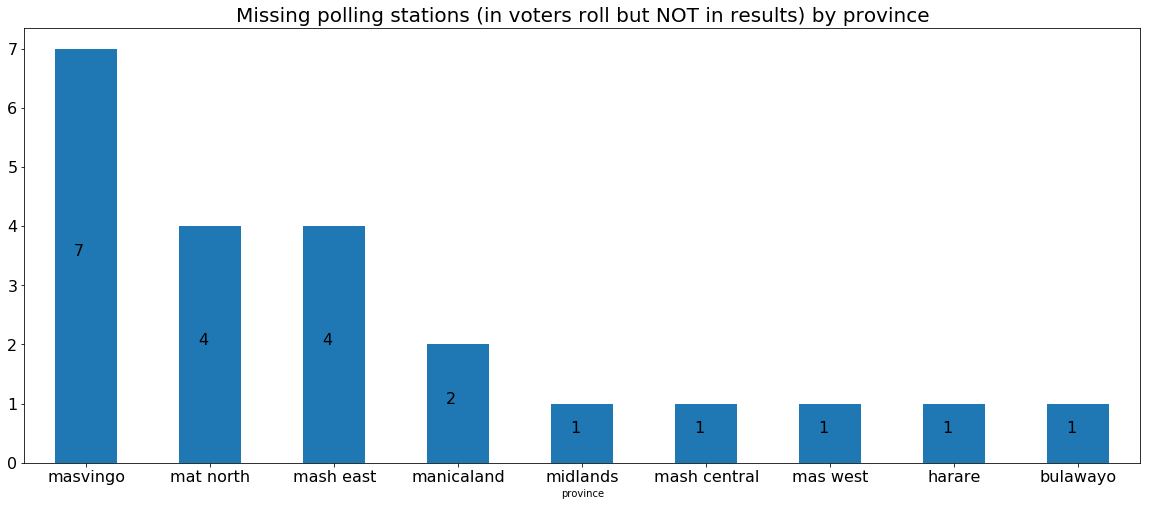

In [1047]:
d = dmiss_byprov.iloc[:,1].sort_values(ascending=False)
g = d.plot(kind="bar", figsize=(20,8),title="Missing polling stations (in voters roll but NOT in results) by province", fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for i in range(len(d)):
    g.text(i-0.1, d[i]/2,  d.iloc[i], fontsize=16)

### Total registered voters at missing polling stations by province
Masvingo had the highest number of voters (2335 of the total 8804) at polling stations found in voters roll but not in the election results. This was closely followed by Harare.

In [1048]:
dmiss_byprov.sum()

tot_count  sum      8804
           count      22
dtype: int64

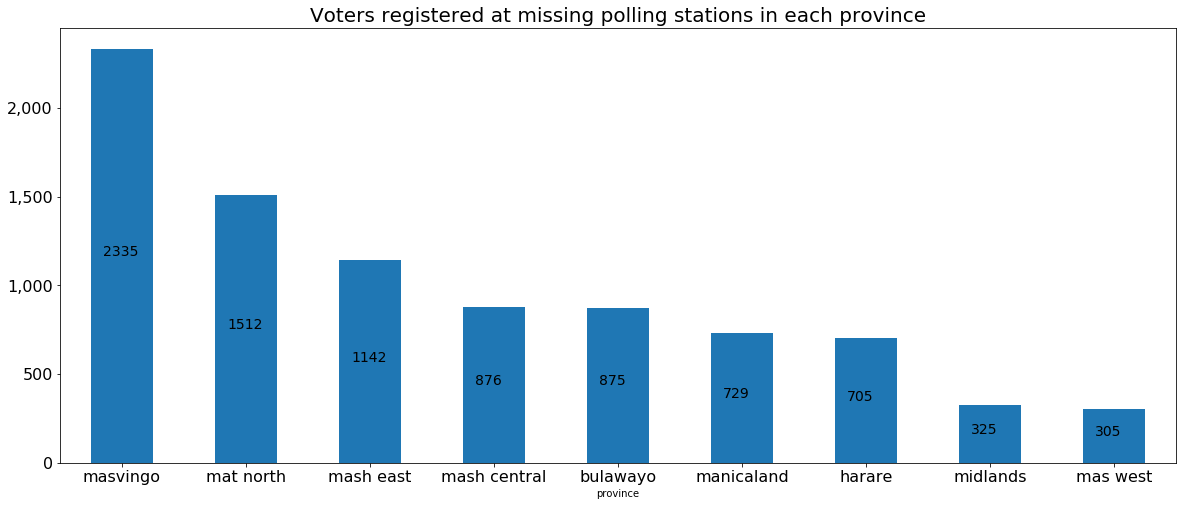

In [1109]:
d =dmiss_byprov.iloc[:,0].sort_values(ascending=False)
g = d.plot(kind="bar",figsize=(20,8), title="Voters registered at missing polling stations in each province", fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for i in range(len(d)):
    g.text(i-0.15, d[i]/2,  d.iloc[i], fontsize=14)
g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

## PART 4 -  "New" polling stations: in election results but NOT in voters roll
-------
There were a total of 3 polling stations found in the results but not in the voters roll. These 3 stations cast 1203 votes with 1191 being valid votes

In [1050]:
selcol = ['province', 'district', 'constituency', 'local_authority', 'ward_no',
       'polling_stations', 'station_code', 
       #'busha_joseph_makamba_freezim_congress', 
         'chamisa_nelson_mdc_alliance',
       #'chikanga__everisto_washington_rebuild_zimbabwe',
       #'dzapasi_melbah_#_1980_freedom_movement_zimbabwe',
       #'gava_peter_mapfumo_udf', 'hlabangana_kwanele_rpz',
       #'kasiyamhuru_blessing_zpp', 'khupe_thokozani_mdc-t',
       #'madhuku_lovemore_nca', 'mangoma_elton_steers_coalition_of_democrats',
       #'manyika_noah_ngoni_bza',
       #'mapfumo_chiguvare_tonderayi_johannes_timothy_pppz',
       #'mariyacha_violet_udm', 'mhambi-hove_divine_napdr',
       'mnangagwa_emmerson_dambudzo_zanu_pf',
        #  'moyo_donald_nkosana_apa',
       #'mteki_bryn_taurai_independent', 'mugadza_willard_tawonezvi_bcp',
       #'mujuru_joice_teurai_ropa_prc', 'munyanduri_tenda_peter_npf',
       #'mutinhiri_ambrose_npf', 'shumba_kuzozvirava_doniel_uda',
       #'wilson_peter_harry_dop',
 #'total_votes_rejected',
       #'ballot_paper_unaccounted_for',
          'total_votes_cast',
       'total_valid_votes_cast'
          #, 'province'
         ]

In [1051]:
# See the polling stations
dnew = dresults[dresults['station_code'].isin(new)].sort_values(by=['province'])
dnew[selcol].iloc[:,:7]

,province,district,constituency,local_authority,ward_no,polling_stations,station_code
4915,mash east,murewa,murewa west,murewa rdc,27,zengenene primary school,4700mre270
8752,mat north,umguza,umguza,umguza rdc,16,mbundani open space a tent,8400umg1607 a
8753,mat north,umguza,umguza,umguza rdc,16,mbundani open space b tent,8400umg1608 b


## PART 5 -  Duplicated polling stations within the election results
-------
There were a total of 7 polling stations appearing more than once in the election results. These 7 stations appeared twice each in the results. In total they represented 4116 and 4060 of total votes cast and total valid votes respectively. If in fact, these were duplicated, the numbers would be 2008 and 2030 instead. In these duplicated stations, the votes going to differnt candidates changes, with a tendency to inflate the numbers for Mnangagwa while deflating Chamisa numbers
    
    - For example, station (chakonera primary school, 0400bkt2101) has 95 and 162 for Chamisa and Mnangagwa respectively in the first instance, but then has 68 and 200 in the second instance.
    - This pattern is dominant in the other duplicated stations as well

In [1052]:
# See the polling stations
ddups = dresults[dresults['station_code'].isin(dups)].sort_values(by=['station_code'])
ddups[selcol].iloc[:,:7]

,province,district,constituency,local_authority,ward_no,polling_stations,station_code
6607,masvingo,bikita,bikita east,bikita rdc,21,chakonera primary school,0400bkt2101
6999,masvingo,chivi,chivi central,chivi rdc,18,gwitima business centre hall,0400bkt2101
6608,masvingo,bikita,bikita east,bikita rdc,21,chikumbo business centre tent,0400bkt2102
7000,masvingo,chivi,chivi central,chivi rdc,18,gwitima primary school,0400bkt2102
6609,masvingo,bikita,bikita east,bikita rdc,21,chisungo secondary school,0400bkt2103
7001,masvingo,chivi,chivi central,chivi rdc,18,jaka chishozhowa secondary school,0400bkt2103
6610,masvingo,bikita,bikita east,bikita rdc,21,dombwe village tent,0400bkt2104
7002,masvingo,chivi,chivi central,chivi rdc,18,mhosva primary school,0400bkt2104
6611,masvingo,bikita,bikita east,bikita rdc,21,rwambiwa primary school,0400bkt2105
7003,masvingo,chivi,chivi central,chivi rdc,18,muzogwi primary school,0400bkt2105


### Chamisa vs Mnangagwa in the diffrent insatances of duplicated polling stations

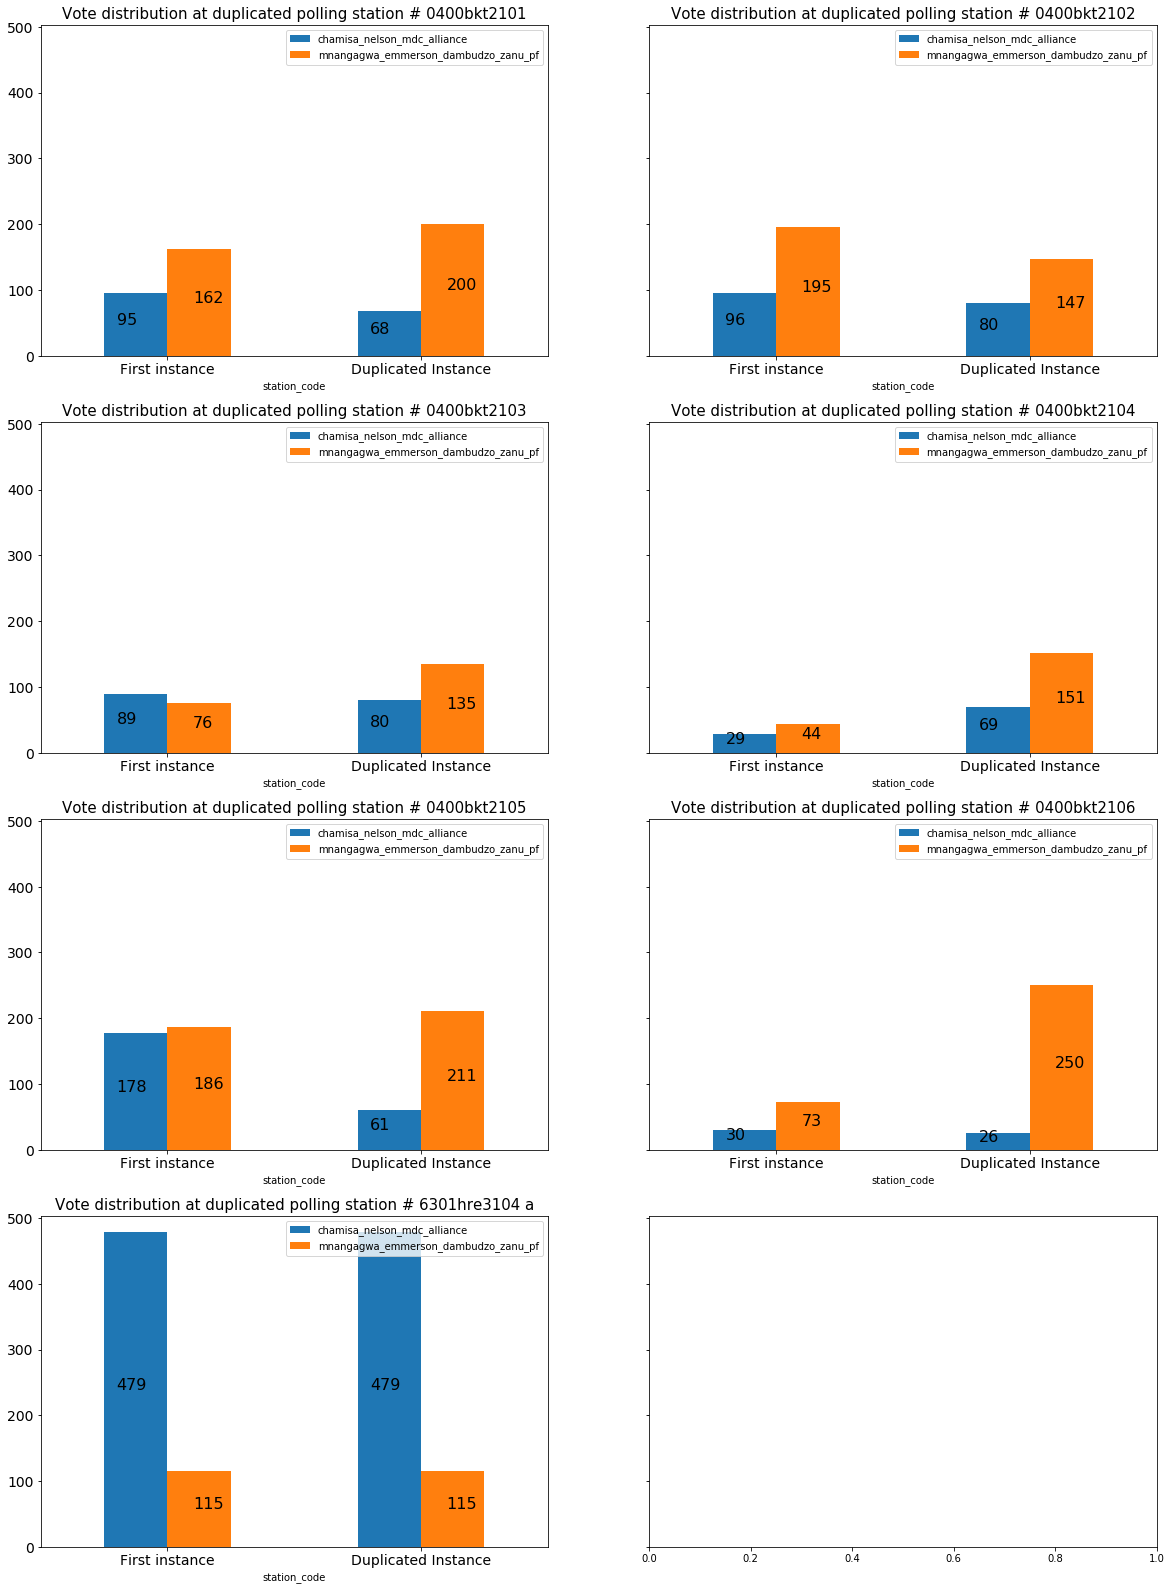

In [1053]:
aa = ddups['station_code'].unique()
df1 = ddups[selcol][['station_code','chamisa_nelson_mdc_alliance','mnangagwa_emmerson_dambudzo_zanu_pf']].set_index(['station_code'])

f, axes = plt.subplots(4, 2, figsize=(20,28), sharey=True)
xl = list(itertools.chain(*axes))

for i in range(len(aa)):
    d = df1.loc[aa[i]]
    #print(d)
    d.plot(kind="bar", ax=xl[i], title="Vote distribution at duplicated polling station # "+ aa[i], fontsize=14)
    xl[i].set_xticklabels(['First instance', 'Duplicated Instance'],rotation=0)
    xl[i].title.set_size(15)
    for j in [0,1]:
        xl[i].text(j-0.2, d.iloc[j,0]/2,  d.iloc[j,0], fontsize=16)
        xl[i].text(j+0.1,d.iloc[j,1]/2,  d.iloc[j,1], fontsize=16)

### Total votes cast vs. total valid votes at duplicated polling stations - by station

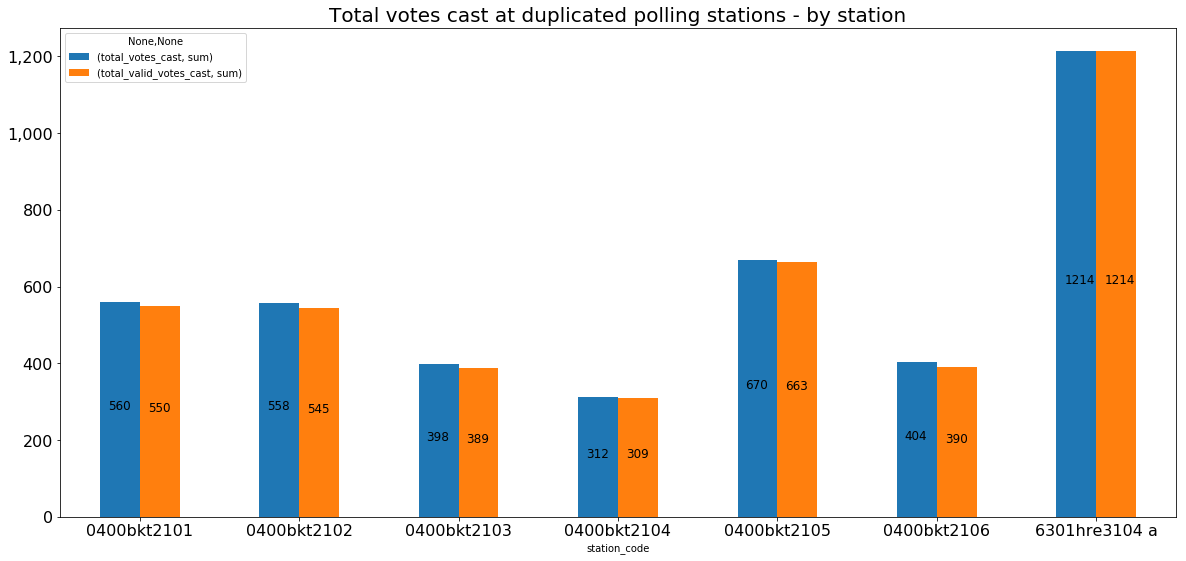

In [1108]:
d =ddups[selcol].groupby(['station_code']).agg(['sum'])[['total_votes_cast', 'total_valid_votes_cast']]
g=d.plot(kind="bar", figsize=(20,9), fontsize=16, title="Total votes cast at duplicated polling stations - by station")
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for j in range(len(d)):
    g.text(j-0.2, d.iloc[j,0]/2,  d.iloc[j,0], fontsize=12)
    g.text(j+0.05,d.iloc[j,1]/2,  d.iloc[j,1], fontsize=12)

g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

# PART 6 - Voter TurnOut
-------

In [1055]:
# prep
over90 = d_election[d_election['voter_turnout_valid']>=0.9]
over95 = d_election[d_election['voter_turnout_valid']>=0.95]
over100 = d_election[d_election['voter_turnout_valid']>=1.0]

dfs = [over90, over95 ,over100]
pcts = ['90', '95', '100']

for i in range(len(pcts)):
    print("Numnber of Polling Stations with Over + {0}% Voter Turnout is : {1}  ".format(pcts[i], dfs[i].shape[0]))

Numnber of Polling Stations with Over + 90% Voter Turnout is : 630  
Numnber of Polling Stations with Over + 95% Voter Turnout is : 32  
Numnber of Polling Stations with Over + 100% Voter Turnout is : 12  


### 6a) Over 90% Voter Turnout
#####################################

In [1056]:
#over90.columns
630/10985

0.05735093309057806

#### The polling stations with very high voter turnout - total 630 stations out of 10985 i.e. 5.74% of all the polling stations

In [1057]:
pol90= over90[['polling_station_code', 'polling_station_name', 'province_vot', 'total_valid_votes_cast',
             'tot_count','voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct', 
       'chamisa_nelson_mdc_alliance','mnangagwa_emmerson_dambudzo_zanu_pf','others_excl_NCandED'
              ]];
pol90.columns = ['polling_station_code', 'polling_station_name', 'province_vot', 'total_valid_votes_cast',
             'tot_count','voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct', 
       'chamisa_votes','mnangagwa_votes','others_votes'
              ];
pol90.to_excel("pollingstations_voterturnout_over90pct.xlsx")
pol90.shape

(630, 12)

#### Comparing results at normal polling stations vs at the high turnout polling stations

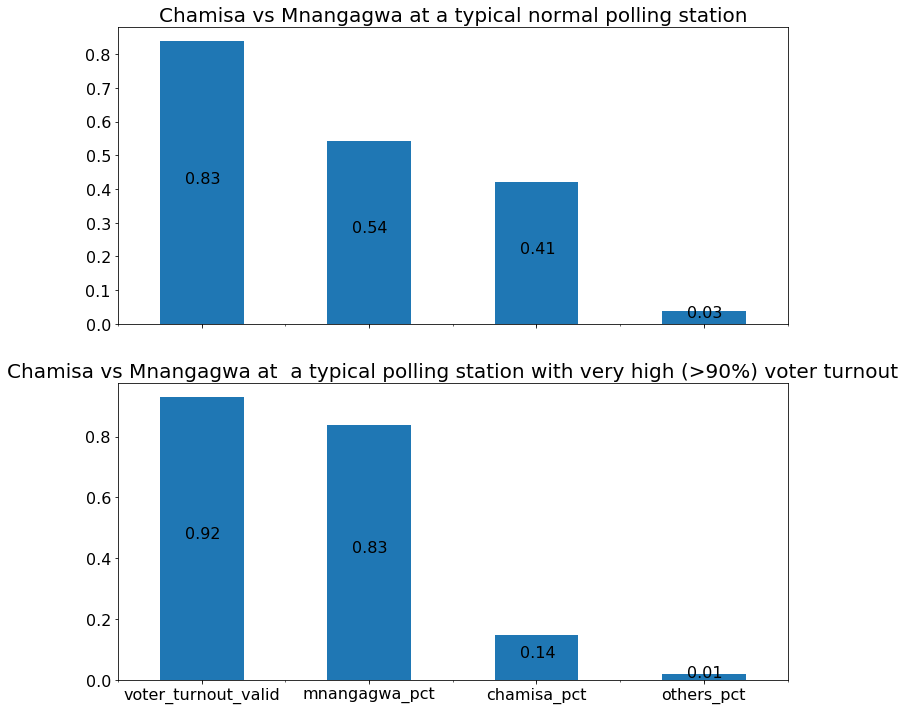

In [1058]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

d1=d_election[['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct']].mean()
d1.plot(kind="bar", ax=ax1, fontsize=16)
d2 =pol90[['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct']].mean()
d2.plot(kind="bar", ax=ax2, fontsize=16)

ax1.set_title('Chamisa vs Mnangagwa at a typical normal polling station')
ax2.set_title('Chamisa vs Mnangagwa at  a typical polling station with very high (>90%) voter turnout')


ax1.set_xticklabels(['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct'],rotation=0)
ax1.title.set_size(20)

ax2.set_xticklabels(['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct'],rotation=0)
ax2.title.set_size(20)


for j in range(4):
    ax1.text(j-0.1, d1[j]/2,  str(d1[j])[:4], fontsize=16)
    ax2.text(j-0.1,d2[j]/2,  str(d2[j])[:4], fontsize=16)


f.set_figheight(12)
f.set_figwidth(12)

#### Distribution of the 630 high turnout polling stations by province

In [1059]:
prov90 = pol90.groupby(['province_vot']).agg(['count'])['tot_count']
#prov90.reset_index(inplace=True)
prov90.columns = ['stations_with_over90%']

In [1060]:
d

,total_votes_cast,total_valid_votes_cast
,sum,sum
station_code,,
0400bkt2101,560,550
0400bkt2102,558,545
0400bkt2103,398,389
0400bkt2104,312,309
0400bkt2105,670,663
0400bkt2106,404,390
6301hre3104 a,1214,1214


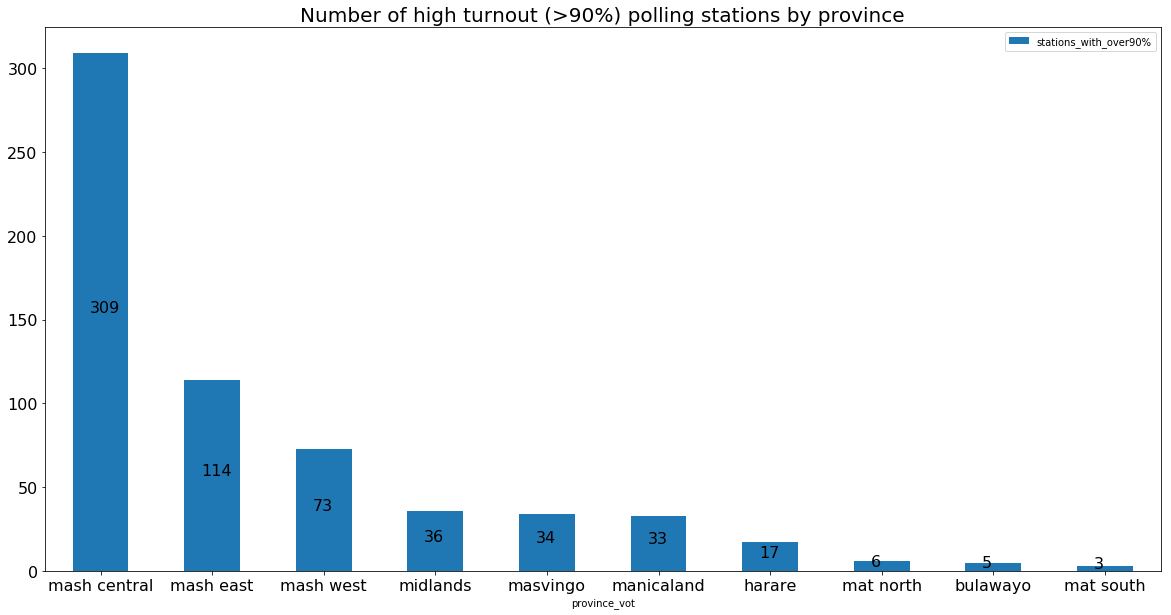

In [1061]:
d = prov90.sort_values(by='stations_with_over90%', ascending=False)
g = d.plot(kind="bar", stacked=False, title="Number of high turnout (>90%) polling stations by province",figsize=(20,10), fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for j in range(len(d)):
    g.text(j-0.1, d.iloc[j,0]/2,  str(d.iloc[j,0]), fontsize=16)

#### Who got the most number of votes at these 630 high turnout polling stations?

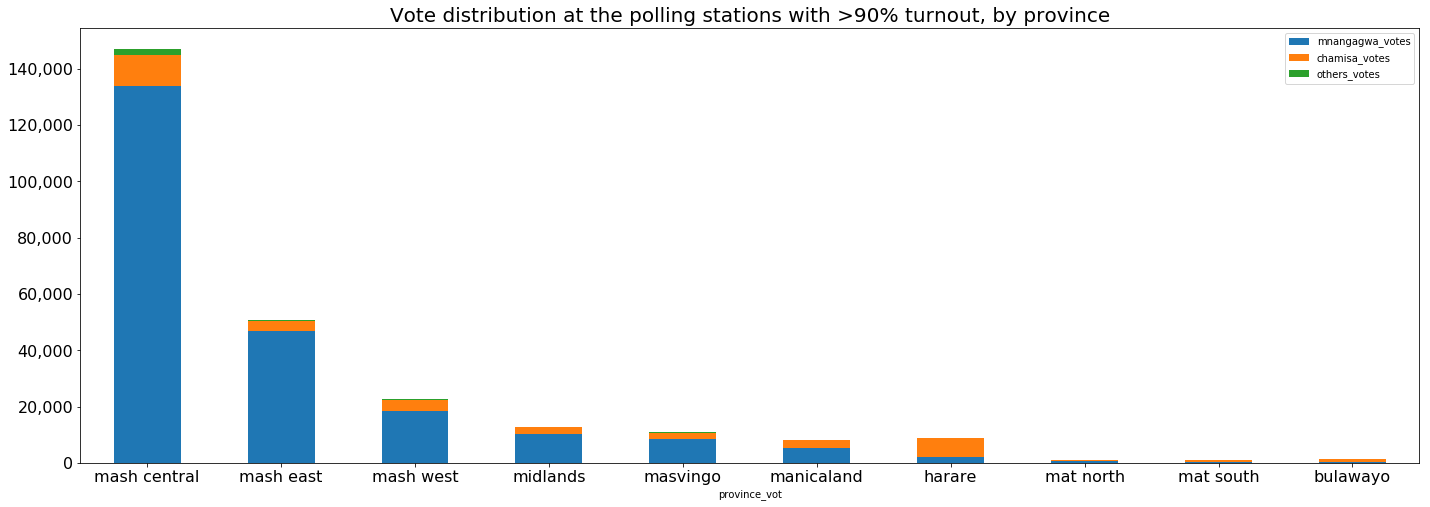

In [1107]:
d = pol90.groupby(['province_vot']).agg('sum')[['mnangagwa_votes','chamisa_votes','others_votes']].sort_values(
    by=["mnangagwa_votes"], ascending=False)
g = d.plot(kind="bar", stacked=True, figsize=(24,8), fontsize=16, title="Vote distribution at the polling stations with >90% turnout, by province")
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
#for i in range(len(d)):
#    g.text(i-0.2, d.iloc[i,0]/2,  d.iloc[i,0], fontsize=9)
#    g.text(i-0.2, d.iloc[i,0]+d.iloc[i,1]/2,  d.iloc[i,1], fontsize=9)
#    g.text(i-0.2, d.iloc[i,0]+d.iloc[i,1]+d.iloc[i,2]/2,  d.iloc[i,2], fontsize=9)

g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

In [1063]:
d

,mnangagwa_votes,chamisa_votes,others_votes
province_vot,,,
mash central,133999,10915,2257
mash east,46931,3382,444
mash west,18559,3869,408
midlands,10143,2480,291
masvingo,8462,2236,269
manicaland,5289,2683,212
harare,2101,6640,140
mat north,575,493,87
mat south,409,625,25


## a) Over 95% Voter Turnout
################################

In [1064]:
#over95.columns
32/10985

0.002913063268092854

#### The polling stations with very high voter turnout of over 95% - total 32 stations out of 10985 i.e. 0.29% of all the polling stations

In [1065]:
pol95= over95[['polling_station_code', 'polling_station_name', 'province_vot', 'total_valid_votes_cast',
             'tot_count','voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct', 
       'chamisa_nelson_mdc_alliance','mnangagwa_emmerson_dambudzo_zanu_pf','others_excl_NCandED'
              ]];
pol95.columns = ['polling_station_code', 'polling_station_name', 'province_vot', 'total_valid_votes_cast',
             'tot_count','voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct', 
       'chamisa_votes','mnangagwa_votes','others_votes'
              ];
pol95[['polling_station_code', 'polling_station_name', 'province_vot', 'total_valid_votes_cast',
             'tot_count','voter_turnout_valid']]

,polling_station_code,polling_station_name,province_vot,total_valid_votes_cast,tot_count,voter_turnout_valid
185,0300mbg1702,rusvinge primary school,midlands,674,422,1.597156
414,0400bkt2103,chisungo secondary school,masvingo,222,196,1.132653
416,0400bkt2104,dombwe village tent,masvingo,234,87,2.689655
420,0400bkt2106,gangare primary school,masvingo,284,126,2.253968
448,0400bkt2707,savuli compound hall,masvingo,6,6,1.000000
473,0500bin0104 a,manga primary school,mash central,731,766,0.954308
479,0500bin0205,mazunga primary school,mash central,501,519,0.965318
480,0500bin0206,terregwai farm tent,mash central,134,139,0.964029
484,0500bin0304,hinton estates tent,mash central,465,483,0.962733
485,0500bin0305,lagnaha farm tent,mash central,521,547,0.952468


In [1066]:
# NUmber of staions with over 95% turnout
pol95.shape[0]

32

#### Comparing results at normal polling stations vs at the high turnout (>95%) polling stations

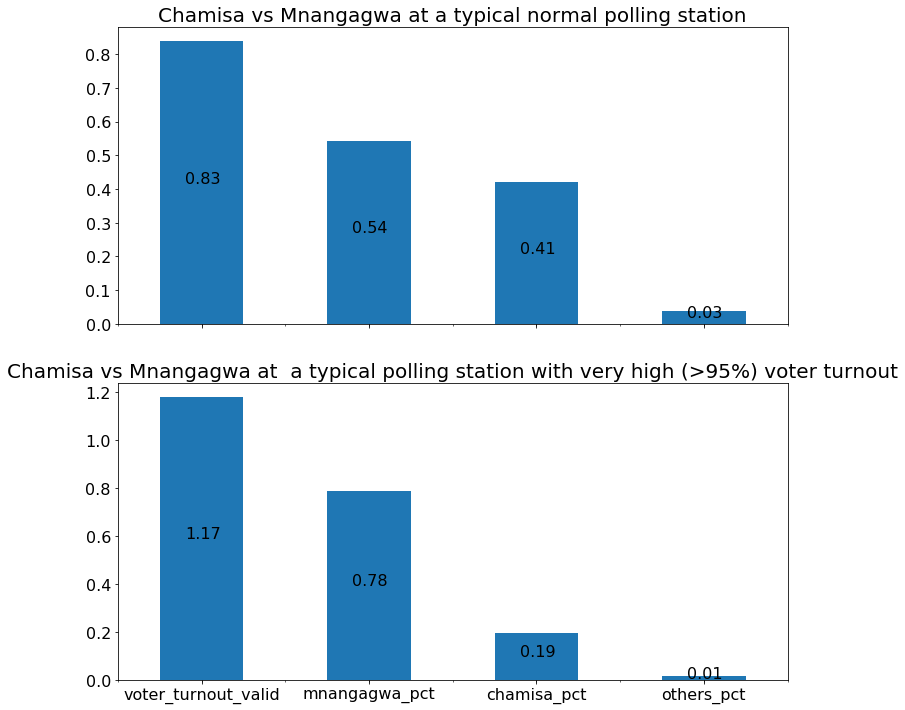

In [1067]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

d1=d_election[['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct']].mean();d1.plot(kind="bar", ax=ax1, fontsize=16)
d2=pol95[['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct']].mean();d2.plot(kind="bar", ax=ax2, fontsize=16)

ax1.set_title('Chamisa vs Mnangagwa at a typical normal polling station')
ax2.set_title('Chamisa vs Mnangagwa at  a typical polling station with very high (>95%) voter turnout')


ax1.set_xticklabels(['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct'],rotation=0)
ax1.title.set_size(20)

ax2.set_xticklabels(['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct'],rotation=0)
ax2.title.set_size(20)

for j in range(4):
    ax1.text(j-0.1, d1[j]/2,  str(d1[j])[:4], fontsize=16)
    ax2.text(j-0.1,d2[j]/2,  str(d2[j])[:4], fontsize=16)

f.set_figheight(12)
f.set_figwidth(12)

#### Distribution of the 32 high turnout (>95%) polling stations by province

In [1068]:
prov95 = pol95.groupby(['province_vot']).agg(['count'])['tot_count']
#prov90.reset_index(inplace=True)
prov95.columns = ['stations_with_over90%']

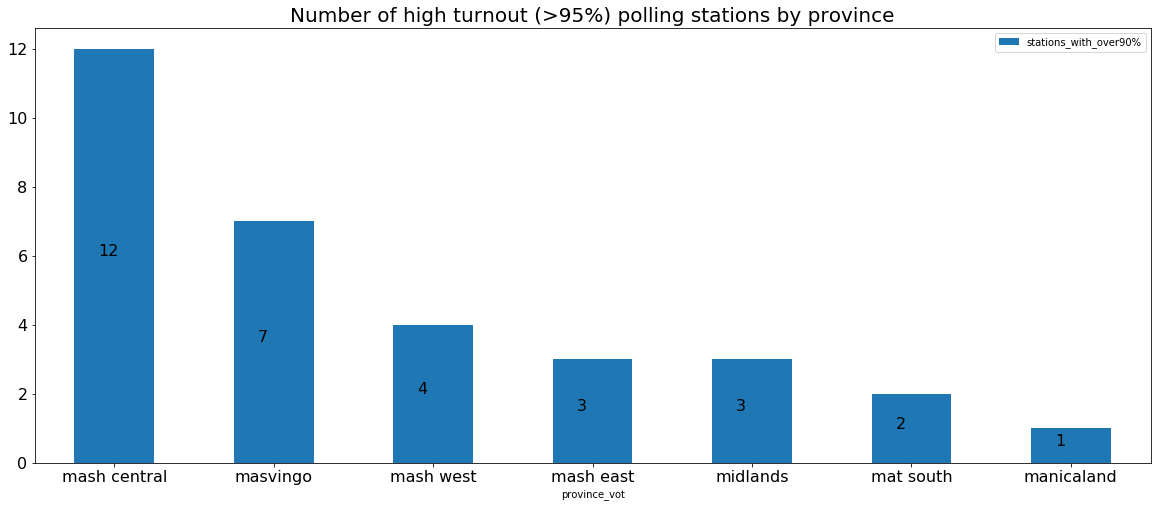

In [1069]:
d = prov95.sort_values(by='stations_with_over90%', ascending=False)
g = d.plot(kind="bar", stacked=False, title="Number of high turnout (>95%) polling stations by province",figsize=(20,8), fontsize=16)                                                                   
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for j in range(len(d)):
    g.text(j-0.1, d.iloc[j,0]/2,  str(d.iloc[j,0]), fontsize=16)

#### Who got the most number of votes at these 32 high turnout (>95%) polling stations?

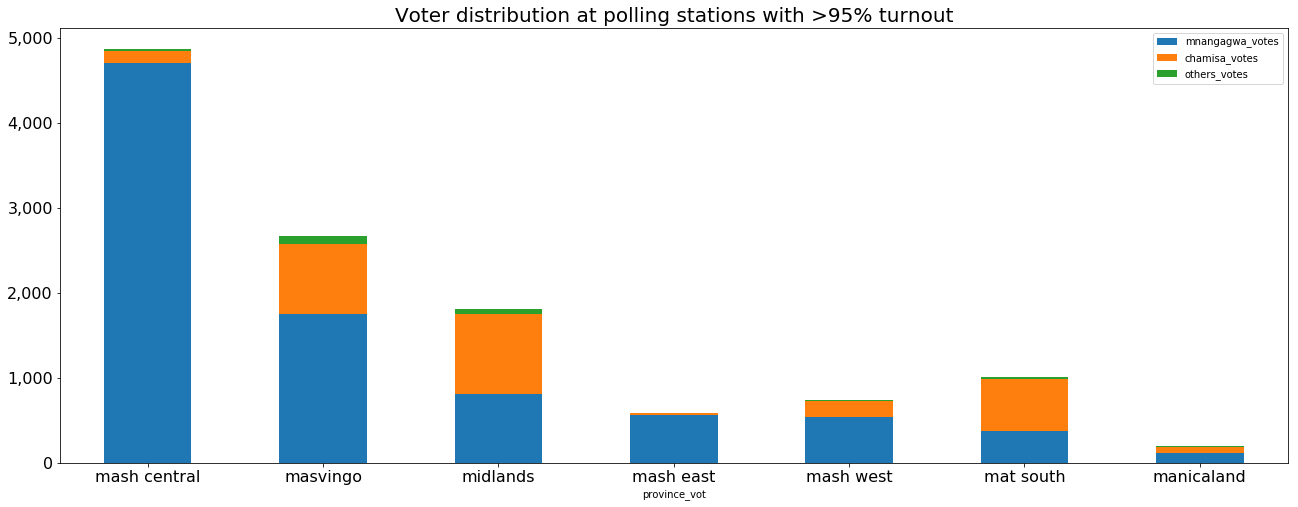

In [1106]:
d =pol95.groupby(['province_vot']).agg('sum')[['mnangagwa_votes','chamisa_votes','others_votes']].sort_values(
    by=["mnangagwa_votes"], ascending=False)
g = d.plot(kind="bar", stacked=True, figsize=(22,8), title="Voter distribution at polling stations with >95% turnout", fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

In [1071]:
d

,mnangagwa_votes,chamisa_votes,others_votes
province_vot,,,
mash central,4710,133,32
masvingo,1753,824,89
midlands,806,952,48
mash east,560,23,1
mash west,537,194,13
mat south,373,618,23
manicaland,115,76,3


## a) Over 100% Voter Turnout
#######################################

In [1072]:
#over100.columns
12/10985

0.0010923987255348202

#### The polling stations with impossible voter turnout of over 100% - total of 12 stations out of 10985 i.e. 0.11% of all the polling stations

In [1073]:
pol100= over100[['polling_station_code', 'polling_station_name', 'province_vot', 'total_valid_votes_cast',
             'tot_count','voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct', 
       'chamisa_nelson_mdc_alliance','mnangagwa_emmerson_dambudzo_zanu_pf','others_excl_NCandED'
              ]];
pol100.columns = ['polling_station_code', 'polling_station_name', 'province_vot', 'total_valid_votes_cast',
             'tot_count','voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct', 
       'chamisa_votes','mnangagwa_votes','others_votes'
              ];
pol100[['polling_station_code', 'polling_station_name', 'province_vot', 'total_valid_votes_cast',
             'tot_count']]

,polling_station_code,polling_station_name,province_vot,total_valid_votes_cast,tot_count
185,0300mbg1702,rusvinge primary school,midlands,674,422
414,0400bkt2103,chisungo secondary school,masvingo,222,196
416,0400bkt2104,dombwe village tent,masvingo,234,87
420,0400bkt2106,gangare primary school,masvingo,284,126
448,0400bkt2707,savuli compound hall,masvingo,6,6
2174,1401ctc0702,chiredzi government b secondary school,masvingo,850,473
4067,2801gwm0402,jahunda primary school,mat south,806,461
4228,2901gwem0506,senga b secondary school,midlands,544,402
4239,2901gwem0702,mambo b secondary school,midlands,588,539
4518,3201chm0803,west end tent,mash west,212,189


In [1074]:
# NUmber of staions with over 95% turnout
pol100.shape[0]

12

#### Comparing results at normal polling stations vs at the impossible turnout (>100%) polling stations

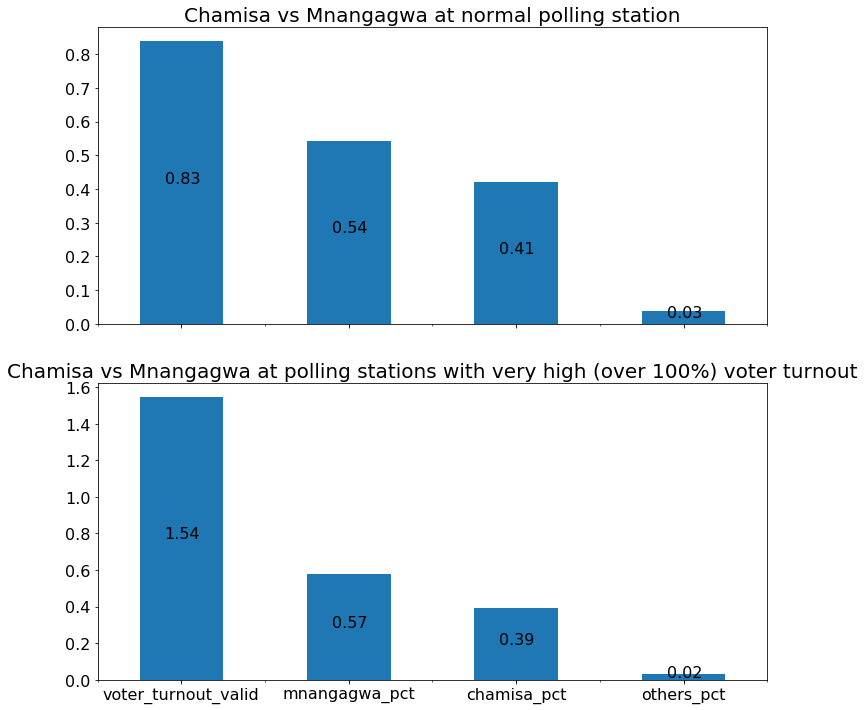

In [1075]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

d1=d_election[['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct']].mean(); d1.plot(kind="bar", ax=ax1, fontsize=16)
d2=pol100[['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct']].mean(); d2.plot(kind="bar", ax=ax2, fontsize=16)

ax1.set_title('Chamisa vs Mnangagwa at normal polling station')
ax2.set_title('Chamisa vs Mnangagwa at polling stations with very high (over 100%) voter turnout')


ax1.set_xticklabels(['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct'],rotation=0)
ax1.title.set_size(20)

ax2.set_xticklabels(['voter_turnout_valid', 'mnangagwa_pct', 'chamisa_pct','others_pct'],rotation=0)
ax2.title.set_size(20)

for j in range(4):
    ax1.text(j-0.1, d1[j]/2,  str(d1[j])[:4], fontsize=16)
    ax2.text(j-0.1,d2[j]/2,  str(d2[j])[:4], fontsize=16)

f.set_figheight(12)
f.set_figwidth(12)

#### Distribution of the 12 impossible turnout (>100%) polling stations by province

In [1076]:
prov100 = pol100.groupby(['province_vot']).agg(['count'])['tot_count']
#prov90.reset_index(inplace=True)
prov100.columns = ['stations_with_over90%']

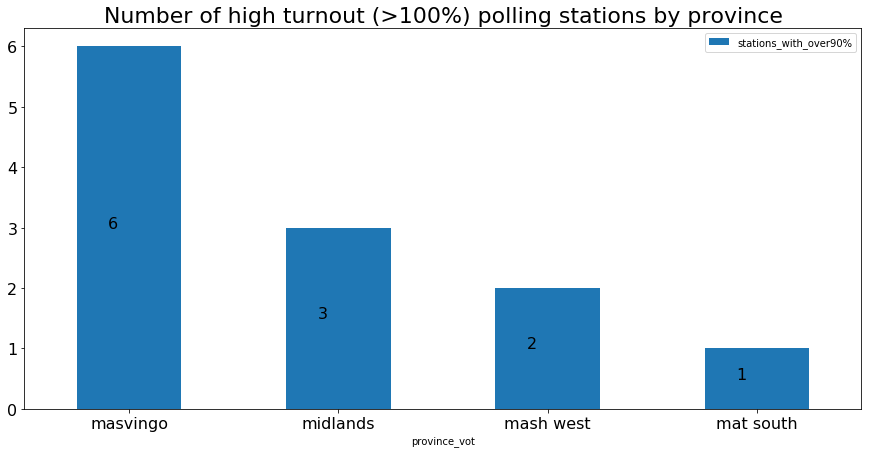

In [1077]:
d=prov100.sort_values(by='stations_with_over90%', ascending=False)
g = d.plot(kind="bar", stacked=False, title="Number of high turnout (>100%) polling stations by province", figsize=(15,7), fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(22)
for j in range(len(d)):
    g.text(j-0.1, d.iloc[j,0]/2,  str(d.iloc[j,0]), fontsize=16)

#### Who got the most number of votes at these 12 impossible turnout (>100%) polling stations?

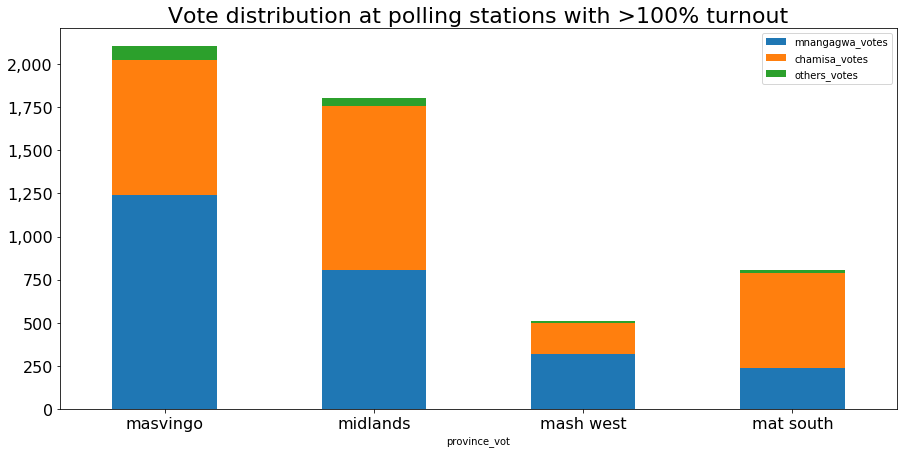

In [1105]:
d=pol100.groupby(['province_vot']).agg('sum')[['mnangagwa_votes','chamisa_votes','others_votes']].sort_values(
    by=["mnangagwa_votes"], ascending=False)
g = d.plot(kind="bar", stacked=True, figsize=(15,7), fontsize=16, title="Vote distribution at polling stations with >100% turnout")
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(22)
g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

In [1079]:
d

,mnangagwa_votes,chamisa_votes,others_votes
province_vot,,,
masvingo,1241,783,79
midlands,806,952,48
mash west,318,182,10
mat south,240,548,17


# PART 7 - Investigate Totals per Polling Station - mathematical integrity within the election results

In [1080]:
# prep
above = dvotcalc[dvotcalc['chamisa_nelson_mdc_alliance'] + dvotcalc['mnangagwa_emmerson_dambudzo_zanu_pf'] +
       dvotcalc['total_votes_rejected'] + dvotcalc['ballot_paper_unaccounted_for'] + dvotcalc['others_excl_NCandED'] > dvotcalc['total_votes_cast']]
equal = dvotcalc[dvotcalc['chamisa_nelson_mdc_alliance'] + dvotcalc['mnangagwa_emmerson_dambudzo_zanu_pf'] +
       dvotcalc['total_votes_rejected'] + dvotcalc['ballot_paper_unaccounted_for'] + dvotcalc['others_excl_NCandED'] == dvotcalc['total_votes_cast']]
below = dvotcalc[dvotcalc['chamisa_nelson_mdc_alliance'] + dvotcalc['mnangagwa_emmerson_dambudzo_zanu_pf'] +
       dvotcalc['total_votes_rejected'] + dvotcalc['ballot_paper_unaccounted_for'] + dvotcalc['others_excl_NCandED'] < dvotcalc['total_votes_cast']]

df_totals = [under, equal ,above]
pcts = ['BELOW 100', 'EQUAL TO 100', 'ABOVE 100']

for i in range(len(pcts)):
    print("Numnber of Polling Stations where sum of candidate votes plus rejected and unaccounted are {0}% of the recorded total is : {1}  ".format(pcts[i], df_totals[i].shape[0]))

Numnber of Polling Stations where sum of candidate votes plus rejected and unaccounted are BELOW 100% of the recorded total is : 5  
Numnber of Polling Stations where sum of candidate votes plus rejected and unaccounted are EQUAL TO 100% of the recorded total is : 10558  
Numnber of Polling Stations where sum of candidate votes plus rejected and unaccounted are ABOVE 100% of the recorded total is : 94  


In [1081]:
above_diff = above['chamisa_nelson_mdc_alliance'] + above['mnangagwa_emmerson_dambudzo_zanu_pf'] + above[
    'total_votes_rejected'] + above['ballot_paper_unaccounted_for'] + above['others_excl_NCandED'] - above['total_votes_cast']

In [1082]:
equal_diff = equal['chamisa_nelson_mdc_alliance'] + equal['mnangagwa_emmerson_dambudzo_zanu_pf'] + equal['total_votes_rejected']+ equal[
    'ballot_paper_unaccounted_for'] + equal['others_excl_NCandED'] - equal['total_votes_cast']

In [1083]:
below_diff =below['chamisa_nelson_mdc_alliance'] + below['mnangagwa_emmerson_dambudzo_zanu_pf'] + below['total_votes_rejected'] + below[
    'ballot_paper_unaccounted_for'] + below['others_excl_NCandED'] - below['total_votes_cast']

### Polling stations where candidate totals summed up to MORE than recorded total
- 94 sites in total
-  accounted for a difference of 291 votes

In [1084]:
above_diff.sum()

291.0

In [1085]:
above.head()

,district,constituency,local_authority,ward_no,polling_stations,station_code,chamisa_nelson_mdc_alliance,mnangagwa_emmerson_dambudzo_zanu_pf,total_votes_rejected,ballot_paper_unaccounted_for,total_votes_cast,total_valid_votes_cast,province,others_excl_NCandED
16,bulawayo,bulawayo central,bulawayo municipality,2,hugh beadle primary school a,0801byo0207 a,470,238,7.0,4.0,736,729,bulawayo,21.0
19,bulawayo,bulawayo central,bulawayo municipality,2,montgomery hall,0801byo0209,450,197,4.0,1.0,697,693,bulawayo,46.0
65,bulawayo,bulawayo east,bulawayo municipality,3,st thomas aquinas primary school,0801byo0311,467,173,6.0,1.0,672,666,bulawayo,26.0
73,bulawayo,bulawayo east,bulawayo municipality,4,hillside junior school a,0801byo0403 a,386,192,1.0,2.0,595,594,bulawayo,16.0
86,bulawayo,bulawayo south,bulawayo municipality,6,barham green primary school,0801byo0602,544,194,6.0,1.0,772,766,bulawayo,28.0


### Polling stations where candidate totals summed up to LESS than recorded total 
- accounted for a difference of 8 votes
- 5 sites total, 3 in Masvingo, 2 in Midlands

In [1086]:
below_diff.sum()

-8.0

In [1087]:
below

,district,constituency,local_authority,ward_no,polling_stations,station_code,chamisa_nelson_mdc_alliance,mnangagwa_emmerson_dambudzo_zanu_pf,total_votes_rejected,ballot_paper_unaccounted_for,total_votes_cast,total_valid_votes_cast,province,others_excl_NCandED
6584,bikita,bikita east,bikita rdc,16,betha primary school,0400bkt1601,145,300,7.0,0.0,472,471,masvingo,19.0
6585,bikita,bikita east,bikita rdc,16,chenerwi business centre tent,0400bkt1602,141,252,7.0,0.0,424,423,masvingo,23.0
6589,bikita,bikita east,bikita rdc,16,chinyamapere primary school,0400bkt1606,258,132,19.0,0.0,434,430,masvingo,21.0
9467,chirumanzu,chirumanzu,takawira rdc,8,charandura council hall,7700tak0802,192,161,2.0,0.0,366,363,midlands,10.0
9485,chirumanzu,chirumanzu,takawira rdc,23,govere primary school,7700tak2301,134,181,4.0,0.0,332,327,midlands,12.0


In [1088]:
polabove= above[['station_code', 'polling_stations', 'province', 'total_valid_votes_cast',
       'chamisa_nelson_mdc_alliance','mnangagwa_emmerson_dambudzo_zanu_pf','others_excl_NCandED'
              ]];
polabove.columns = ['station_code', 'polling_stations', 'province', 'total_valid_votes_cast',
       'chamisa_votes','mnangagwa_votes','others_votes'
              ];
polabove[['station_code', 'polling_stations', 'province', 'total_valid_votes_cast',
       'chamisa_votes','mnangagwa_votes','others_votes'
              ]].shape

(94, 7)

In [1089]:
above.to_excel("pollingstations_with_wrong_totals.xlsx")
polabove.shape[0]

94

In [1090]:
provabove = polabove.groupby(['province']).agg(['count'])['total_valid_votes_cast']
provabove.columns = ['stations_exceeding_recorded_total']

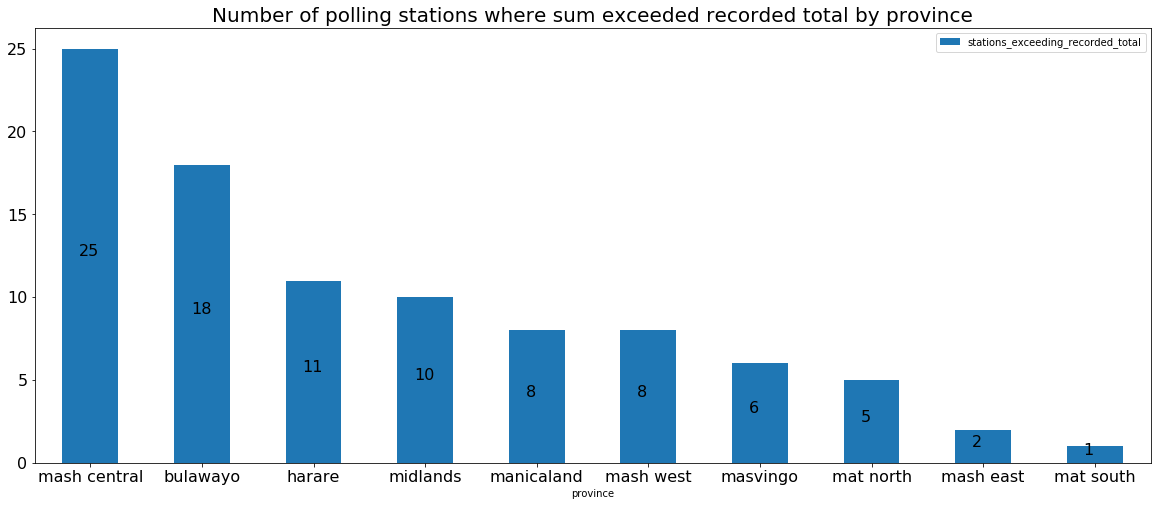

In [1091]:
d = provabove.sort_values(by='stations_exceeding_recorded_total', ascending=False)
g = d.plot(kind="bar", stacked=False, title="Number of polling stations where sum exceeded recorded total by province",figsize=(20,8), fontsize=16)                                                                   
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
for j in range(len(d)):
    g.text(j-0.1, d.iloc[j,0]/2,  str(d.iloc[j,0]), fontsize=16)

#### How were votes distributed at these polling stations where totals didn't match?

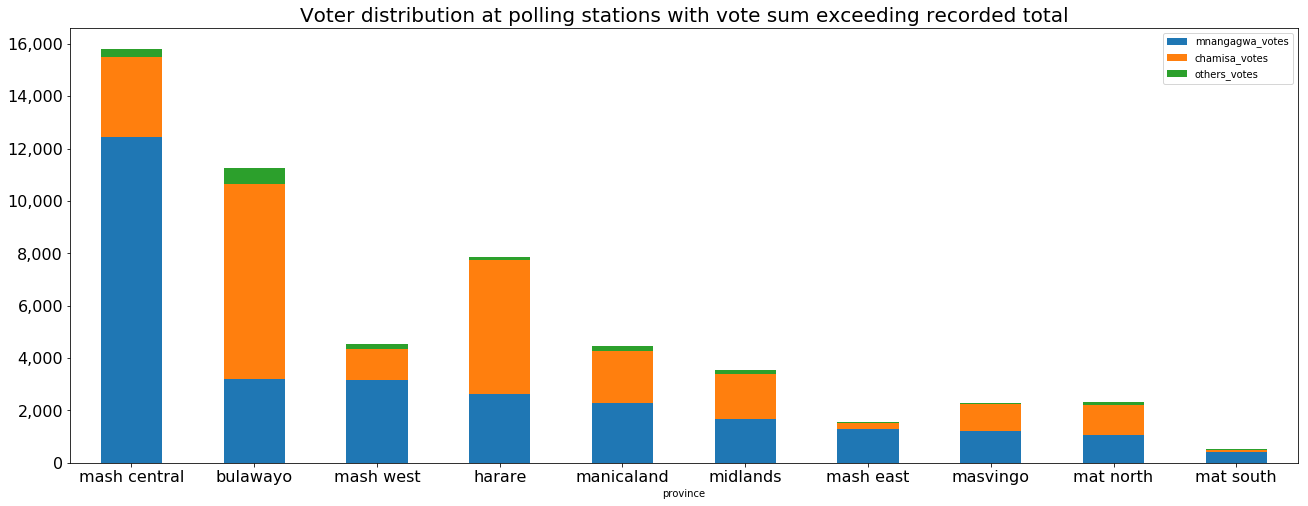

In [1104]:
d =polabove.groupby(['province']).agg('sum')[['mnangagwa_votes','chamisa_votes','others_votes']].sort_values(
    by=["mnangagwa_votes"], ascending=False)
g = d.plot(kind="bar", stacked=True, figsize=(22,8), title="Voter distribution at polling stations with vote sum exceeding recorded total", fontsize=16)
g.set_xticklabels(d.index,rotation=0)
g.title.set_size(20)
g.get_yaxis().set_major_formatter(tic.FuncFormatter(lambda x, p: format(int(x), ',')))

In [1093]:
d

,mnangagwa_votes,chamisa_votes,others_votes
province,,,
mash central,12435,3066,316.0
bulawayo,3218,7442,590.0
mash west,3143,1196,210.0
harare,2639,5103,127.0
manicaland,2278,2009,174.0
midlands,1673,1728,139.0
mash east,1290,235,16.0
masvingo,1207,1026,53.0
mat north,1054,1172,104.0



## Still more analysis can be done e.g. compare with independent sources, compare with parliamentary results etc.
## THE END, for now.

----------